# 5. Computer Vision classification challenge

## Exploratory analysis and baseline model training and evaluation

Use a sample of images from the swimming-pool dataset to develop a model that classifies whether an image contains a swimming pool or not. Use the provided labels to validate your model.

In [2]:
import os

is_kaggle = True if os.environ.get('KAGGLE_URL_BASE', '') else False

if is_kaggle and not os.path.exists("/kaggle/working/ds_code_challenge"):
    print("This notebook is running on Kaggle.")
    print("Installing additional packages...")
    os.system("curl -LsSf https://astral.sh/uv/install.sh | sh")
    os.system("git clone https://github.com/stefan027/ds_code_challenge.git")
    os.system("cd ds_code_challenge && uv pip install -r requirements.txt")

In [3]:
import os
from pathlib import Path
from importlib.metadata import version
from typing import Union
import random

from PIL import Image
import pandas as pd
from IPython.display import display
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import timm
from fastai.vision.all import *

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
pckgs = ["torch", "torchvision", "fastai", "timm"]
for pckg in pckgs:
    print(f"{pckg}=={version(pckg)}")

torch==2.8.0
torchvision==0.23.0
fastai==2.8.4
timm==1.0.20


In [5]:
KAGGLE_IMAGE_DIR = Path("/kaggle/input/cct-ds-code-challenge/images/swimming-pool")
IMAGE_DIR = KAGGLE_IMAGE_DIR if is_kaggle else Path("../data/images/swimming-pool")
CLASSES = ["no", "yes"]
POSITIVE_CLASS = "yes"
VALIDATION_PCT = 0.2

In [6]:
set_seed(42, reproducible=True)

In [7]:
image_paths = [IMAGE_DIR/f"{category}/{f}" for category in CLASSES for f in os.listdir(IMAGE_DIR/category)]

In [8]:
# Check the file extensions and get value counts
pd.Series([fp.suffix for fp in image_paths]).value_counts()

.tif    7043
           2
Name: count, dtype: int64

In [9]:
# Remove non-TIF files
image_paths = [fp for fp in image_paths if fp.suffix.lower() == ".tif"]
print(f"Number of image files: {len(image_paths)}")

Number of image files: 7043


In [10]:
# id2label = dict(enumerate(CLASSES))
# label2id = {v: k for k, v in id2label.items()}
# label2id

In [11]:
# def get_label(fp: Union[str, Path], mapping: dict = None) -> str:
#     """Extracts the label from the file path."""
#     label = Path(fp).parts[-2]
#     if mapping is not None:
#         return mapping[label]
#     return label

In [12]:
def get_label(fp: Union[str, Path], positive_class: str) -> str:
    """Extracts the label from the file path."""
    label = Path(fp).parts[-2]
    return int(label == positive_class)

In [13]:
# get_label(image_paths[0], mapping=label2id)
get_label(image_paths[0], POSITIVE_CLASS)

0

In [14]:
# labels = [get_label(fp, mapping=label2id) for fp in image_paths]
labels = [get_label(fp, POSITIVE_CLASS) for fp in image_paths]
# Look at class distribution
pd.Series(labels).value_counts()

1    4643
0    2400
Name: count, dtype: int64

In [15]:
valid_idx = sorted(random.sample(range(len(image_paths)),
                                 k=int(len(image_paths)*VALIDATION_PCT)))
train_idx = sorted(list(set(range(len(image_paths))) - set(valid_idx)))
train_fps, train_labels = [image_paths[i] for i in train_idx], [labels[i] for i in train_idx]
valid_fps, valid_labels = [image_paths[i] for i in valid_idx], [labels[i] for i in valid_idx]
print(f"Training set size:   {len(train_fps)}")
print(f"Validation set size: {len(valid_fps)}")

Training set size:   5635
Validation set size: 1408


Path: /kaggle/input/cct-ds-code-challenge/images/swimming-pool/no/W17D_8_5.tif, Label: 0


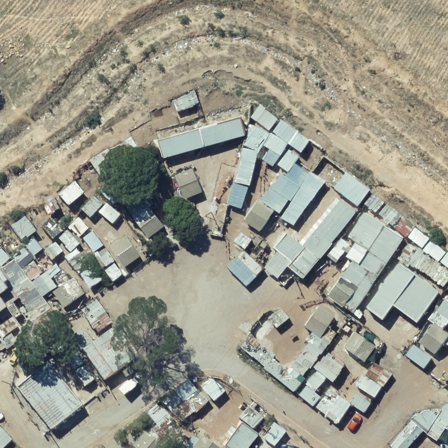

Path: /kaggle/input/cct-ds-code-challenge/images/swimming-pool/yes/W34C_20_79.tif, Label: 1


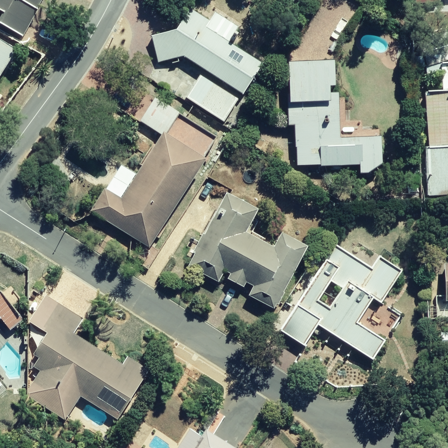

In [16]:
# Look at some sample images
sz = (448, 448)
for _ in range(2):
    i = random.randint(0, len(image_paths)-1)
    print(f"Path: {image_paths[i]}, Label: {labels[i]}")
    display(Image.open(image_paths[i]).resize(sz))

In [17]:
class TiffImageDataset(Dataset):
    """
    PyTorch Dataset for reading .tif images and preparing them for image classification.
    """

    def __init__(self, paths, labels=None, transform=None):
        """
        Args:
            paths (list): List of file paths to .tif images.
            labels (list, optional): List of integer labels corresponding to each image. 
                                     If None, dataset returns only images.
            transform (callable, optional): Optional transform to be applied to each image.
        """
        self.paths = paths
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(self.device)

        if self.labels is not None:
            label = self.labels[idx]
            # return image, torch.tensor([label], dtype=torch.long, device=self.device)
            # return image, torch.tensor([label], dtype=torch.float, device=self.device)
            return image, torch.tensor(label, dtype=torch.float, device=self.device)
        else:
            return image

In [18]:
ds_trn = TiffImageDataset(paths=train_fps, labels=train_labels)
ds_val = TiffImageDataset(paths=valid_fps, labels=valid_labels)

In [19]:
dls_trn = DataLoader(ds_trn, batch_size=16, shuffle=True)
dls_val = DataLoader(ds_val, batch_size=16, shuffle=False)
dls = DataLoaders(dls_trn, dls_val)

In [20]:
x, y = dls.one_batch()
print(f"Image tensor shape: {x.shape}")
print(f"Label tensor shape: {y.shape}")

Image tensor shape: torch.Size([16, 3, 224, 224])
Label tensor shape: torch.Size([16])


In [21]:
def create_timm_model(
    arch, n_out, pretrained=True, n_in=3, init=nn.init.kaiming_normal_,
    custom_head=None, concat_pool=True, lin_ftrs=None, ps=0.5,
    first_bn=True, bn_final=False, lin_first=False, y_range=None, **kwargs
):
    """
    Modified from fastai.vision.learner.create_timm_model to correctly cut the head
    for Timm models.
    Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library
    """
    model = timm.create_model(arch, pretrained=pretrained, num_classes=0, in_chans=n_in, **kwargs)
    nf = model.num_features
    pool = model.default_cfg.get('pool_size', None) is not None
    if custom_head is None:
        head = create_head(nf, n_out, concat_pool=concat_pool, pool=pool, lin_ftrs=lin_ftrs, ps=ps,
                           first_bn=first_bn, bn_final=bn_final, lin_first=lin_first, y_range=y_range)
        if init is not None:
            apply_init(head, init)
        model.head = head
    else:
        model.head = custom_head
    return model, model.default_cfg

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, cfg = create_timm_model("convnext_tiny", n_out=1, pretrained=True)
model = model.to(device)

In [23]:
with torch.no_grad():
    logits = model(x)
logits.shape, logits

(torch.Size([16, 1]),
 tensor([[-2.6656],
         [ 0.3331],
         [-3.4907],
         [ 0.7380],
         [-1.2276],
         [-1.3368],
         [ 0.4343],
         [-1.8310],
         [-0.6381],
         [-2.2303],
         [ 3.3295],
         [ 3.5862],
         [-0.8415],
         [ 0.6117],
         [ 1.1695],
         [ 0.9672]], device='cuda:0'))

In [24]:
class BinaryClassificationMetric(Metric):
    def __init__(self, func, thres=None):
        self.func = func
        self.thres = thres

    def reset(self):
        self.preds, self.targs = [], []

    def accumulate(self, learn):
        preds_batch = learn.pred.detach().cpu().flatten()
        if self.thres is not None:
            preds_batch = (preds_batch > self.thres).float()
        preds_batch = preds_batch.numpy().tolist()
        targs_batch = learn.yb[0].detach().cpu().flatten().numpy().tolist()
        self.preds += preds_batch
        self.targs += targs_batch

    @property
    def value(self):
        if self.preds:
            return self.func(torch.tensor(self.preds), torch.tensor(self.targs))
        return None

    @property
    def name(self):
        return self.func.name

In [25]:
learn = Learner(
    dls, model, loss_func=BCEWithLogitsLossFlat(), opt_func=Adam,
    metrics=[
        BinaryClassificationMetric(BalancedAccuracy(), thres=0.5),
        BinaryClassificationMetric(APScoreBinary()),
        BinaryClassificationMetric(Precision(), thres=0.5),
        BinaryClassificationMetric(Recall(), thres=0.5),
        BinaryClassificationMetric(RocAucBinary())
    ]
)

In [26]:
learn.summary()

ConvNeXt (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 96 x 56 x 56   
Conv2d                                    4704       True      
LayerNorm2d                               192        True      
Identity                                                       
Conv2d                                    4800       True      
LayerNorm                                 192        True      
____________________________________________________________________________
                     16 x 56 x 56 x 384  
Linear                                    37248      True      
GELU                                                           
Dropout                                                        
Identity                                                       
____________________________________________________________________________
                     16 x 56 x 56 x 96   
Linear                               

In [27]:
# Freeze all parameters except for the classification head
def _freeze_except_head():
    """Freeze all model parameters except for those in the classification head."""
    for name, param in model.named_parameters():
        if name.split(".")[0] == "head":
            param.requires_grad = True
        else:
            param.requires_grad = False

def _unfreeze_all():
    """Unfreeze all model parameters."""
    for param in model.parameters():
        param.requires_grad = True

In [28]:
_freeze_except_head()

In [29]:
# learn.lr_find()

In [30]:
# Train the classification head for one epoch
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,balanced_accuracy_score,average_precision_score,precision_score,recall_score,roc_auc_score,time
0,0.355657,0.262747,0.873466,0.969964,0.911351,0.915309,0.952701,08:28


In [31]:
_unfreeze_all()
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,balanced_accuracy_score,average_precision_score,precision_score,recall_score,roc_auc_score,time
0,0.299250,0.264048,0.878282,0.971448,0.905956,0.941368,0.954250,09:47
1,0.279591,0.253393,0.885963,0.971747,0.920824,0.921824,0.955847,09:25
2,0.243484,0.259395,0.874116,0.972695,0.902923,0.939197,0.956301,09:19


In [32]:
os.makedirs("./models", exist_ok=True)
torch.save(learn.model.state_dict(), "./models/classification_model_v0.pth")